# Analysis of scATAC-seq data in human peripheral blood mononuclear cells
#### Training Camp, September 8, 2020

We will focus on a human peripheral blood mononuclear cell dataset from 10x Genomics and perform analysis in the Seurat/Signac workflows. Additional vignettes that expand the scope of what is possible with these data available here: https://satijalab.org/signac/articles/overview.html. Oh, apparently, the importance of [Seurat and Signac](https://www.google.com/search?q=signac+seurat&source=lnms&tbm=isch) happens to also extend beyond the field of single-cell biology.

In this notebook, we are starting with already preprocessed data. However, going from .fastq files to these analysis inputs are conceptually similar to what was done for bulk data. To see an overview of the changes related to bulk, check out this link: https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/algorithms/overview

Each section will comprise of a ~10-15 minute introduction/discussion of the code by the instructor followed by ~10-15 minutes of discussion with each breakout group. After the breakout group, we'll reconvene and and answer any last questions before moving on to the next section.

In each section, there is a ["Try it yourself" component](https://media.giphy.com/media/3qQ329Rgle89i/giphy.gif). If you feel comfortable with the provided code, try adding additional cells into the notebook to explore more advanced components of this workflow. If not, think about the questions posed in terms of interpreting the data in a biological or technical context. 


In [1]:
library(Seurat)
library(Signac)
library(chromVAR)
library(motifmatchr)
library(SummarizedExperiment)
library(Matrix)
library(data.table)
library(magrittr)
library(ggplot2)
library(viridis)
library(BSgenome.Hsapiens.UCSC.hg19)
library(EnsDb.Hsapiens.v75)
library(JASPAR2018)
library(TFBSTools)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

# Section 1: File formats and quality control

Check out the [10x QC report](http://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_10k_nextgem/atac_pbmc_10k_nextgem_web_summary.html). Look over the report and try to understand what the metrics represent.

## File formats
These are all emitted from a standard 10x CellRanger-ATAC run as well as other droplet-based ATAC processing pipelines. I expect these to be the standard file formats moving forward.

### Fragments file
A (perhaps) unfamiliar file format that comes as part of the default 10x scATAC-seq processing is a fragments.tsv file. You can read about it more here. Let’s take alook:
```
##      chr start   end            barcode nDup
##  1: chr1 10091 10344 TTCGCGTGTCCAAGAG-1    1
##  2: chr1 10096 10309 TACTAGGCAGAATGCG-1    1
##  3: chr1 10126 10351 TCAGTCCGTCCTTATT-1    2
##  4: chr1 10162 10543 ACTACCCAGGTACATA-1    2
##  5: chr1 10163 10407 AACTGGTAGAGGCCTA-1    1
##  6: chr1 10394 10625 CACGTTCAGCCTGTAT-1    1
##  7: chr1 10462 10500 TAAGTGCAGTCGCCTG-1    2
##  8: chr1 10512 10576 CCTCCCTAGGAATGGA-1    2
##  9: chr1 16221 16285 GGCGAAATCACAGGGA-1    2
## 10: chr1 17446 17527 CCTCCCTAGGAATGGA-1    1
```

A couple of useful tidbits:
* The fragments from this file have been offset to account for Tn5 insertions and their asymmetry (i.e. +4 and -5), meaning the edges can be used for footprinting directly.

* The last column indicates the number PCR duplications that are observed (with the same barcode). However, fragments that map to multiple barcodes are filtered from this file.

* Reads mapping to blacklisted regions are retained and may need to be filtered in some downstream processes. 

* Chimeric reads or reads with a long insert are removed.

**More often than not, I get all of my information from this file for downstream analyses.** Though an analogous file does not exist for scRNA-seq, I absolutely recommend becoming familiar and comfortable utilizing and manipulating this file for most purposes (e.g. computing a peaks x cells matrix with a new peak set).

### More familiar looking files
The contents of the filtered_peak_bc_matrix matches what is familiar to processing pipelines of scRNA-seq with the exception that the feature set (here: peaks; in RNA-seq, genes) is different between experiments, even with the same reference.

In [2]:
# import files
dir <- "/data/singlecell/10k/filtered_peak_bc_matrix/"
barcodes <- fread(paste0(dir, "barcodes.tsv"), header = FALSE)[[1]]
peaks <- fread(paste0(dir, "peaks.bed"), header = FALSE, col.names = c("chr", "start", "end"))
mat <- fread(paste0(dir, "matrix.mtx"), skip = 3, header = FALSE)

In [3]:
# Barcodes look like we'd expect
head(barcodes)

[1] "AAACGAAAGAGCTGTG-1" "AAACGAAAGCCTCGCA-1" "AAACGAAAGCGAGCTA-1"
[4] "AAACGAAAGCGCCTAC-1" "AAACGAAAGGGAGTTC-1" "AAACGAAAGGTGTTGG-1"

In [4]:
# Sparse matrix encoding of data...
head(mat)

V1,V2,V3
<int>,<int>,<int>
90660,1,1
90658,1,2
90585,1,2
90561,1,2
90545,1,2
90543,1,2


In [5]:
# Peaks (featureset)... as called by CellRanger
head(peaks)

chr,start,end
<chr>,<int>,<int>
chr1,565163,565491
chr1,569190,569620
chr1,713551,714783
chr1,752418,753020
chr1,762249,763345
chr1,779771,780224


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



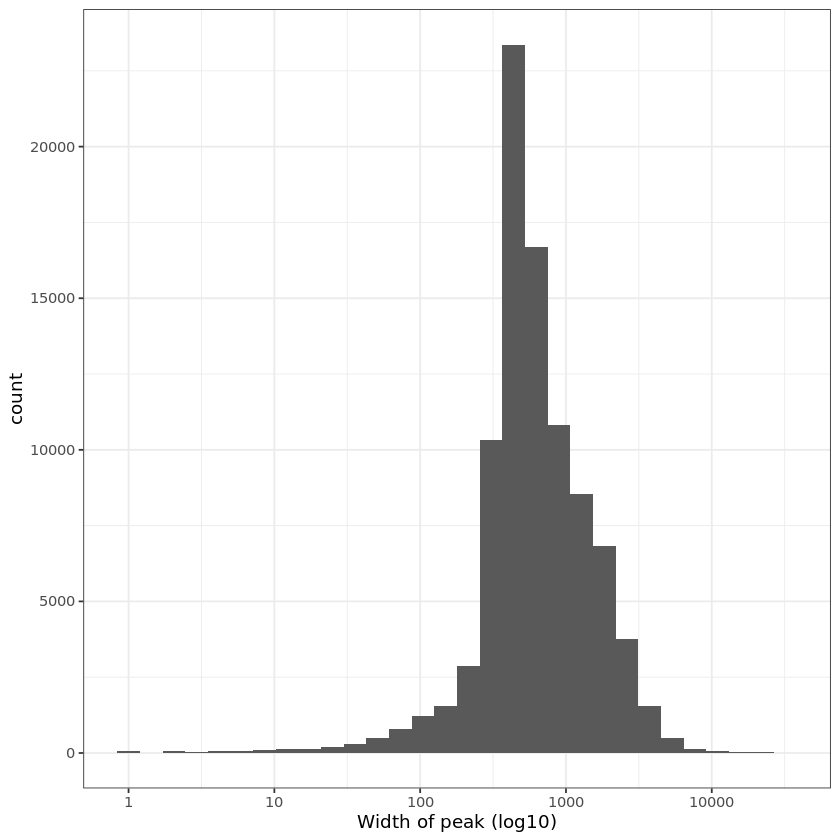

In [6]:
# Now let's look at the distribution of peak widths...
qplot(peaks$end - peaks$start) + scale_x_log10() + labs(x = "Width of peak (log10)", y = "count") + theme_bw()

Notice the wide distribution of the width of peaks– this can yield potential artifacts depending on the exact nature of analysis.



## Try it yourself - 10x QC report
* What are cells with with very high fragment abundance but very low percentage of reads in peaks?
* Why is there a ‘bump’ around position ~200 in the TSS enrichment plot?
* What fraction of reads map to the mitochondrial genome? Is this lower or higher than we’d expect with ATAC-seq?
* Are these libraries sequenced to saturation?
* How are PCR duplicates determined in this assay?

For more on point 1, [read here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5509561/), specifically paragraph number 2 of “Cell-type-specific spatial organization of the accessible genome.”

## Try it yourself - coding
* What is the mean, median, and extreme values for the peak widths above? 
* How many peaks are present on each chromosome? 
* Is there an association between chromosome and the width of the chromosome accessibility peaks detected? 



# Section 2: loading single-cell data and quality control in R
A typical object for analysis of single cell data in R is the "Seurat" object (for use with Signac and Seurat). Here is a custom function that creates this object that utilizies the existing plain text structure. Try to follow the code provided in the function. 

In [7]:
# This code chunk takes a couple of minutes to run
import_10xATAC_seurat <- function(dir, summary_csv_file, fragments_file){
  
  # import files
  barcodes <- fread(paste0(dir, "barcodes.tsv"), header = FALSE)[[1]]
  peaks <- fread(paste0(dir, "peaks.bed"), header = FALSE, col.names = c("chr", "start", "end"))
  rownames <- paste0(peaks$chr, "-", as.character(peaks$start), "-", as.character(peaks$end))
  matdt <- fread(paste0(dir, "matrix.mtx"), skip = 3, header = FALSE)
  
  # Add an extra 0 to ensure the dimension is like we want in creating a sparse matrix
  mat <- Matrix::sparseMatrix(i = c(matdt[[1]],length(peaks)), 
                              j = c(matdt[[2]],length(barcodes)),
                              x = c(matdt[[3]], 0))
  rownames(mat) <- rownames
  colnames(mat) <- barcodes
  
  # Filter out chrY
  mat <- mat[peaks$chr != "chrY",]
    
  # Create the object
  summary_csv <- read.csv(summary_csv_file, row.names = 1, header = TRUE)
    
  chrom_assay <- CreateChromatinAssay(
    counts = mat,
    sep = c("-", "-"),
    genome = 'hg19',
    fragments = fragments_file,
    min.cells = 0,
    min.features = 0
  )
    
  seurat_object <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = summary_csv
  )

    return(seurat_object)
}

seurat_atac <- import_10xATAC_seurat("/data/singlecell/10k/filtered_peak_bc_matrix/", 
                                     "/data/singlecell/10k/atac_pbmc_10k_nextgem_singlecell.csv",
                                     "/data/singlecell/10k/atac_pbmc_10k_nextgem_fragments.tsv.gz")


Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


In [8]:
seurat_atac[["peaks"]]


ChromatinAssay data with 90357 features for 9668 cells
Variable features: 0 
Genome: hg19 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

We can directly access the per-barcode quality control metrics for these cells:

In [9]:
head(seurat_atac@meta.data)

,orig.ident,nCount_peaks,nFeature_peaks,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,cell_id,is__cell_barcode,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAACGAAAGAGCTGTG-1,SeuratProject,17039,7227,23916,10197,285,133,1336,0,11965,_cell_0,1,5505,10388,1731,5707,10905,1,8817,17042
AAACGAAAGCCTCGCA-1,SeuratProject,13734,5518,24139,12904,283,129,1260,0,9563,_cell_1,1,5025,8227,1153,5206,8698,1,7022,13740
AAACGAAAGCGAGCTA-1,SeuratProject,43786,15307,64762,29904,677,334,3199,4,30644,_cell_2,1,13470,26614,4691,13958,28138,11,22700,43815
AAACGAAAGCGCCTAC-1,SeuratProject,13274,5266,20514,9477,271,104,1301,1,9360,_cell_3,1,5253,7924,883,5392,8381,6,6787,13292
AAACGAAAGGGAGTTC-1,SeuratProject,9823,4527,13401,5239,112,59,667,3,7321,_cell_4,1,2942,6257,1158,3104,6584,2,5110,9825
AAACGAAAGGTGTTGG-1,SeuratProject,19216,8054,24877,10257,258,125,1240,0,12997,_cell_5,1,5560,11392,2008,5833,12027,5,9922,19221


## Filtering cells
There are a variety of metrics that one can use to filter cells for downstream analysis. Most commonly, these are used: 1) the total number of high-quality fragments captured for the cell (in this case, the `passed_filter` number reported by CellRanger); 2) the proportion of fragments that map to an expected accessible chromatin region. Most conveniently, this is usually the fraction of reads in peaks (FRIP); however, other metrics such as proportion of reads overlapping annotated transcription start sites (TSSs) can provide a more consistent interpretation of results from experiment to experiment (but we can also observe that these metrics are highly correlated).

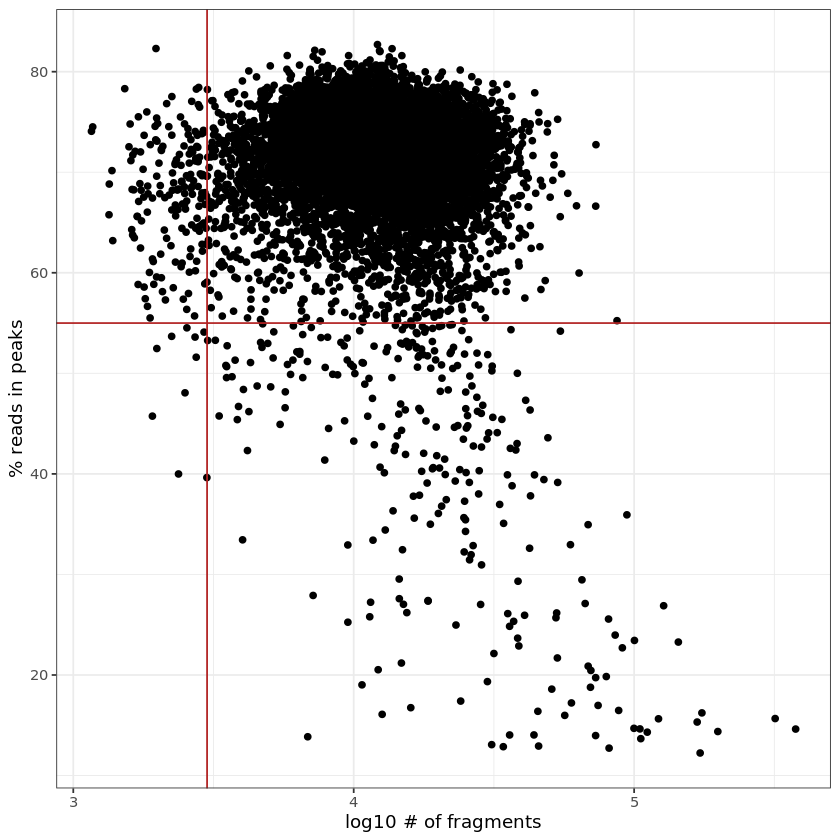

In [10]:
seurat_atac$pct_reads_in_peaks <- seurat_atac$peak_region_fragments / seurat_atac$passed_filters * 100
seurat_atac$pct_reads_in_TSS <- seurat_atac$TSS_fragments / seurat_atac$passed_filters * 100

qplot(log10(seurat_atac$passed_filters),seurat_atac$pct_reads_in_peaks) +
  labs(x = "log10 # of fragments", y = "% reads in peaks") +
  geom_hline(yintercept = 55, color = "firebrick") +
  geom_vline(xintercept = log10(3000), color = "firebrick") + theme_bw()

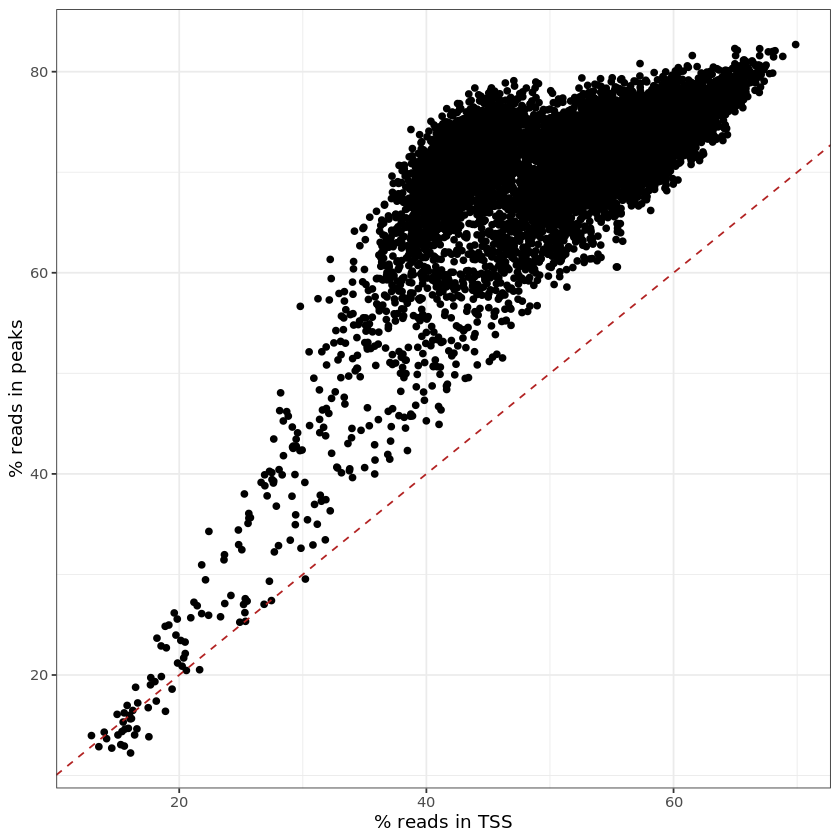

In [11]:
qplot(seurat_atac$pct_reads_in_TSS,seurat_atac$pct_reads_in_peaks) +
  labs(x = "% reads in TSS", y = "% reads in peaks") + theme_bw() +
  geom_abline(intercept = 0, slope = 1, linetype = 2, color = "firebrick")


In [12]:
# Filter object
pbmc <- subset(seurat_atac, subset = pct_reads_in_peaks > 55 & passed_filters > 3000)
dim(pbmc)

[1] 90357  9210

## Try it yourself
* What is a biological/technical explanation for cells that were filtered out based on these QC metrics? 
* How many cells failed QC for each of the filtering criteria? 
* As an approximation, how many reads are in enhancers, promoters, and neither? What QC metrics were used to figure this out?
* Can you compute and examine some more advanced metrics that can be used to filter low quality cells in Signac? Hint: the fragments file, which we will use later, is at this path: `/data/singlecell/10k/atac_pbmc_10k_nextgem_fragments.tsv.gz`


# Section 3: Standard Signac workflow
Utilizing the Signac object, we can call nice wrapper functions to go from our high-dimensional chromatin accessibility data to a two-dimensional cell embedding with possible cell types identified using graph-based clustering.

The [TF-IDF](http://www.tfidf.com/) (term frequency-inverse document frequency) functionality provides a normalization of the data. While in theory, TF-IDF has a singular interpretation, but in scATAC-seq analyses, there’s been a few modifications of it that have lead to some confusion– [see this useful blogpost](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/). The Signac authors provide four such implementations of TF-IDF; these yield roughly the same thing.

In [13]:
# Normalization
# there winds up being very little differences in the four methods from my evaluation
pbmc <- RunTFIDF(pbmc)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"


After completing this normalization, we can perform subsequent steps like finding variable features, linear dimension reduction via SVD (similar to PCA), graph-based clustering, and two-dimensional manifold embedding.

Note: This next code chunk takes about 4-5 minutes on my machine.

In [14]:
# Filter for variable peaks (q50)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q50')

# Run linear dimension reduction (very similar to PCA)
pbmc <- RunSVD(
  object = pbmc,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

# Commands for a 2D embedding and graph-based clustering
set.seed(2020)
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindClusters(object = pbmc, verbose = FALSE)

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
07:07:20 UMAP embedding parameters a = 0.9922 b = 1.112

07:07:20 Read 9210 rows and found 29 numeric columns

07:07:20 Using Annoy for neighbor search, n_neighbors = 30

07:07:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

07:07:22 Writing NN index file to temp file /tmp/RtmpLw1qt3/file97925482debe

07:07:22 Searching Annoy index using 1 thread, search_k = 3000

07:07:25 Annoy recall = 100%

07:07:27 Commencing smooth kNN distance calibration us

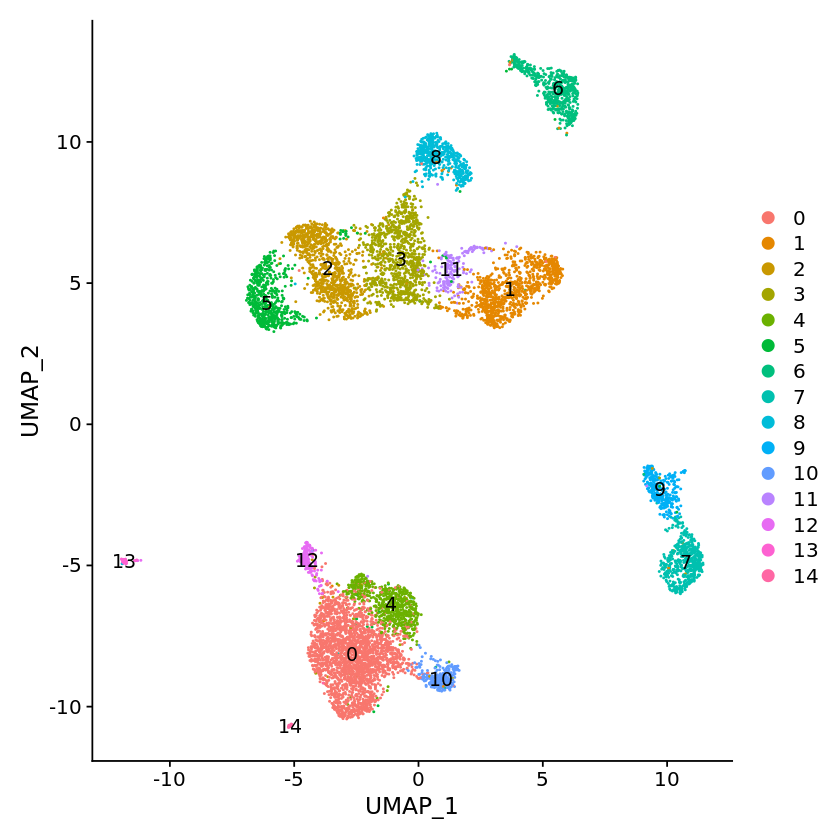

In [15]:
DimPlot(object = pbmc, label = TRUE)

Here, we see that this approach nicely picks out ~15 clusters using a standard workflow. Next, we'll want to try to identify what these clusters are. 

## Compute gene scores using Signac

There have been several proposed methods for computing gene scores from scATAC-seq data. The basic idea is that we want to count accessibel chromatin fragments proximal to annotated gene bodies. These fragments may or may not be weighted. When they are, typical weights include correlation to the promoter of the target gene or the distance from the center of the fragment to the TSS. The most sophisticaed is [Cicero](https://cole-trapnell-lab.github.io/cicero-release/docs_m3/), which utilizes a penalized correlation metric between enhancers and genes to compute these gene scores. What turns out to be the most effective (in my opinion and has been shown in some supplemental figures) is a basic idea introducted in Seurat/Signac to just count all fragments overlapping the gene body extended by 2kb (to include the promoter). This is computationally very efficient to compute. Additionally, this doesn’t rely on peaks for inference, which is very advantageous for merging datasets.

For computational efficiency, we're going to subset to a few genes that we know will be interesting. This filtering is performed in this tutorial to save time, but generally one won't do this. 

In [16]:

# Set up the gene body coordinates
gene.coords <- genes(EnsDb.Hsapiens.v75, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

# Filter to interesting genes
# Generally, you would omit these lines
interesting_features <- c('NCAM1', 'CD4', 'CD8A', 'MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD14')
keep_feature <- genebodyandpromoter.coords$gene_name %in% interesting_features
genebodyandpromoter.coords_filt <- genebodyandpromoter.coords[keep_feature]


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 1 out-of-bound range located on sequence chrM.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information."



In the code chunk below, we use Signac to compute gene scores. The input requires the fragments file, discussed above.


In [17]:
# Point Signac object to fragments file
fragments <- CreateFragmentObject(
  path = "/data/singlecell/10k/atac_pbmc_10k_nextgem_fragments.tsv.gz",
  cells = colnames(pbmc),
  validate.fragments = FALSE
)

# create a gene activity by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragments,
  features = genebodyandpromoter.coords_filt,
  cells = colnames(pbmc)
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- gene.key[rownames(gene.activities)]

# add the gene activity matrix to the Seurat object as a new assay, and normalize it
pbmc[['ACTIVITY']] <- CreateAssayObject(counts = gene.activities)
pbmc <- NormalizeData(
  object = pbmc,
  assay = 'ACTIVITY',
  normalization.method = 'LogNormalize',
  scale.factor = median(pbmc$nCount_ACTIVITY)
)

Computing hash

Extracting reads overlapping genomic regions



By saving the gene score (pseudo-expression) counts in the ACTIVITY slot of the Seurat object, this structure is ready for integration with scRNA-seq data (see vignette URL at the end of the tutorial). However, we'd want to include all gene activity scores (so omit the 3 lines starting with "interesting_features"). 


## Visualize gene activity scores for annotating cell types
Using our reduced dimension data, we can visualize clusters and territories of our embedding for known / interesting marker genes to provide putative annotations for our cell types. 

### Broad cell type marker genes

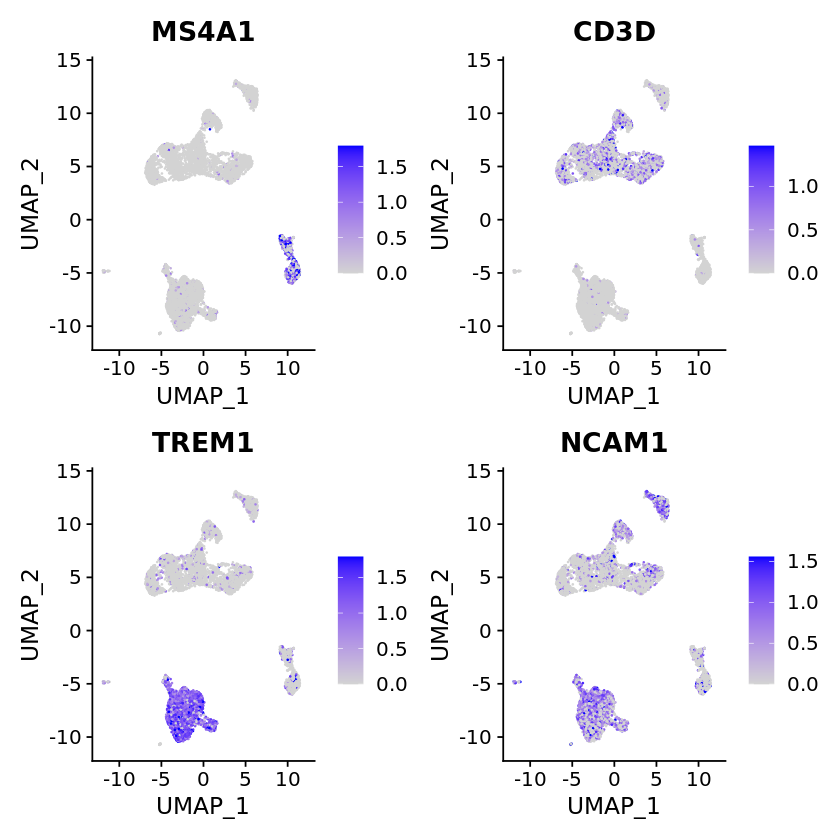

In [18]:
DefaultAssay(pbmc) <- 'ACTIVITY'

FeaturePlot(
  object = pbmc,
  features = c("MS4A1", "CD3D", "TREM1", "NCAM1"),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 2
)

### T-cell markers

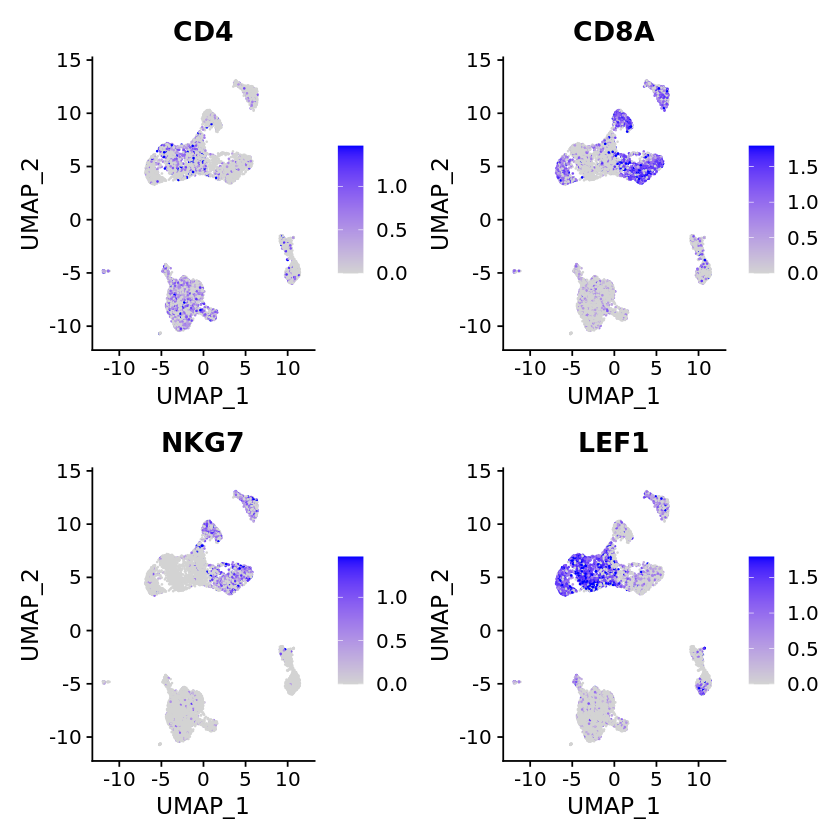

In [19]:
FeaturePlot(
  object = pbmc,
  features = c("CD4", "CD8A", "NKG7", "LEF1"),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 2
)

### Try imputing/smooth gene activity scores
The function below adds a gene score smoothing/imputation assay to the existing Seurat object. The basic idea here is that since single-cell measurements are inherently sparse, we can leverage cells in a high-dimensional space to infer/smooth/impute low or missing values. This is a hot area of single-cell methods development, and many methods have been implemented to achieve this. Here, we're going to use a stripped down version of the [MAGIC](http://gph.is/1KjihQe), errr, wait no, this [MAGIC](https://pubmed.ncbi.nlm.nih.gov/29961576/) software to perform this gene smoothing/imputation. The cell below contains a single function that achieves this functionality. 

In [20]:

# Hard code some parameters from ArchR's function for simplicity
# See: https://github.com/GreenleafLab/ArchR/blob/master/R/Imputation.R
add_imputed_gene_scores_to_seurat <- function(pbmc, k = 20){
    ka = 4
    epsilon = 1
    td = 3
    LSI_mat <- pbmc@reductions$lsi@cell.embeddings[,2:30]

    knnObj <- nabor::knn(data = LSI_mat, query = LSI_mat, k = k)
    knnIdx <- knnObj$nn.idx
    knnDist <- knnObj$nn.dists
    Nx = dim(LSI_mat)[1]
    rm(knnObj)

    if(ka > 0){
        knnDist <- knnDist / knnDist[,ka]
    }

    if(epsilon > 0){
        W <- Matrix::sparseMatrix(rep(seq_len(Nx), k), c(knnIdx), x=c(knnDist), dims = c(Nx, Nx))
    } else {
        W <- Matrix::sparseMatrix(rep(seq_len(Nx), k), c(knnIdx), x=1, dims = c(Nx, Nx)) # unweighted kNN graph
    }
    W <- W + Matrix::t(W)

    #Compute Kernel
    if(epsilon > 0){
        W@x <- exp(-(W@x / epsilon^2))
    }

    #Markov normalization
    W <- W / Matrix::rowSums(W) 

    #Initialize Matrix
    Wt <- W

    #Computing Diffusion Matrix
    for(i in 1:td){
        Wt <- Wt %*% W
    }
    gene.activities.impute <- pbmc@assays$ACTIVITY@counts %*% Wt
    colnames(gene.activities.impute) <- colnames( pbmc@assays$ACTIVITY@counts)
    rownames(gene.activities.impute) <- rownames( pbmc@assays$ACTIVITY@counts)

    pbmc[['IMPUTE']] <- CreateAssayObject(counts = gene.activities.impute)
    pbmc <- NormalizeData(
      object = pbmc,
      assay = 'IMPUTE',
      normalization.method = 'LogNormalize',
      scale.factor = median(pbmc$nCount_IMPUTE)
    )
    pbmc
}


In [21]:
pbmc_imputed <- add_imputed_gene_scores_to_seurat(pbmc)
DefaultAssay(pbmc_imputed) <- 'IMPUTE'

Now, we have a second Seurat object called `pbmc_imputed` that has the additional 'IMPUTE' assay that tracks the imputed gene scores. We can visualize a few of the markers before/after smoothing as shown below. The first set of plots should look familiar as we made them a few lines ago. 

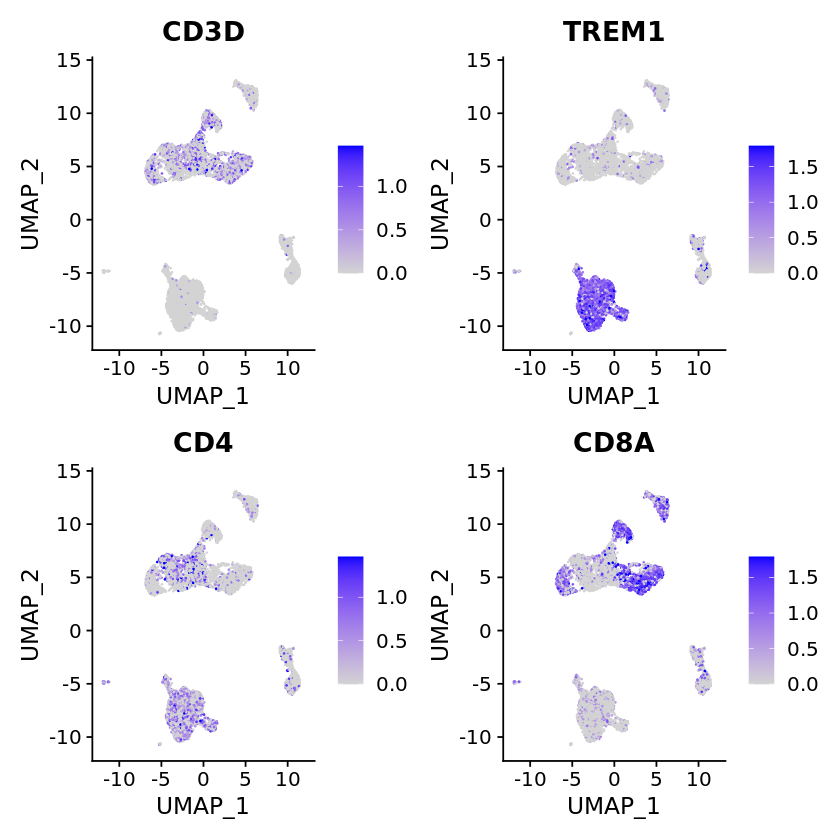

In [22]:
DefaultAssay(pbmc) <- 'ACTIVITY'

FeaturePlot(
  object = pbmc,
  features = c("CD3D", "TREM1","CD4", "CD8A"),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 2
) 

#### Now lets compare these 'raw' gene scores to the imputed visualization from the MAGIC execution

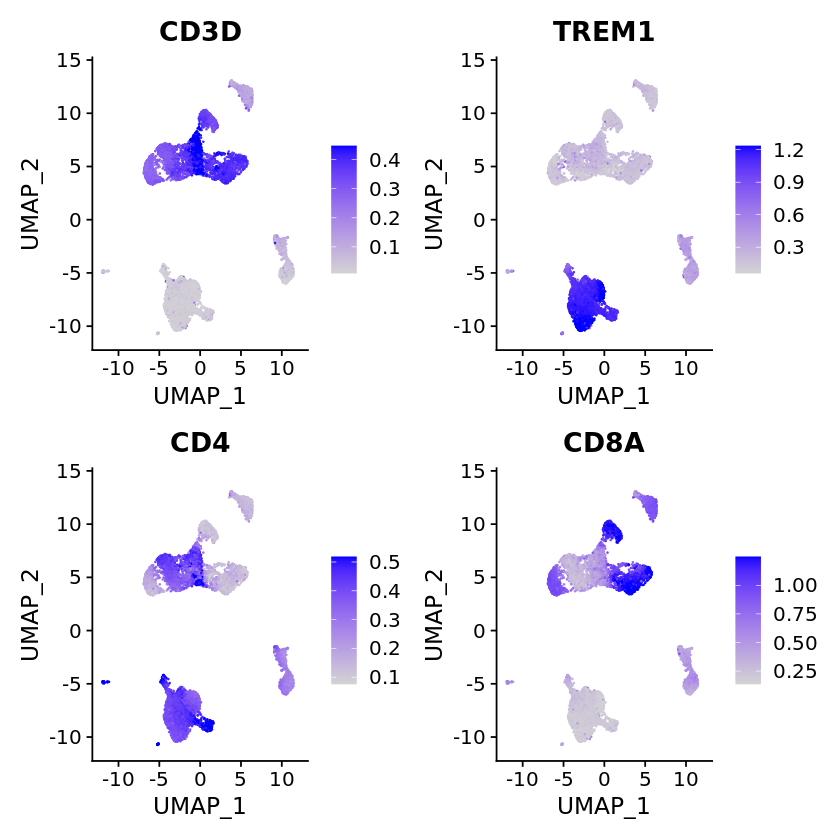

In [23]:
FeaturePlot(
  object = pbmc_imputed,
  features = c("CD3D", "TREM1","CD4", "CD8A"),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 2
) 

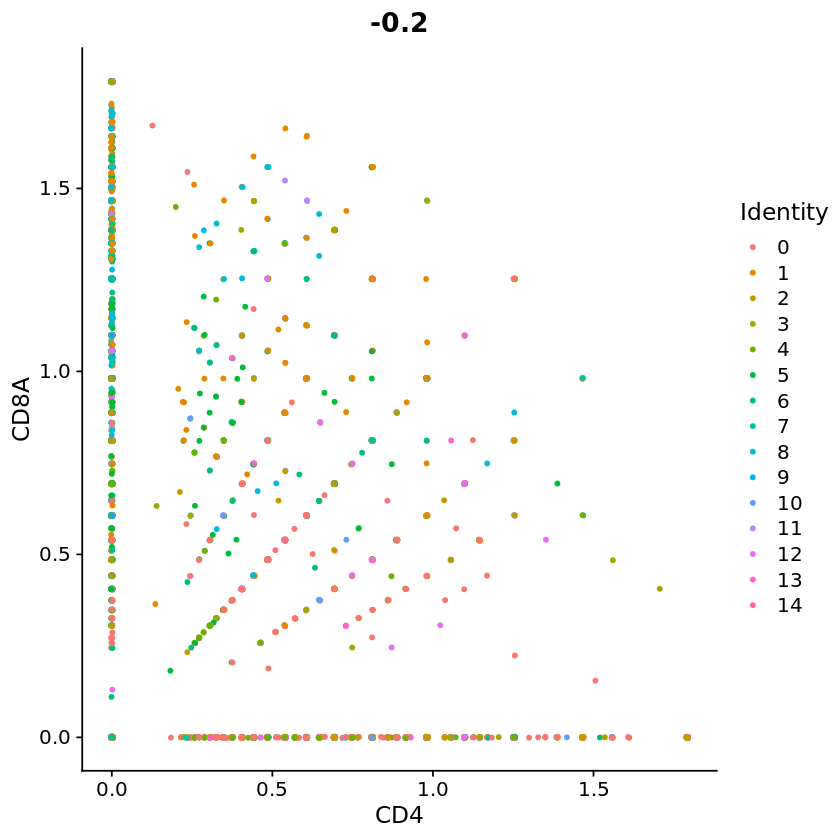

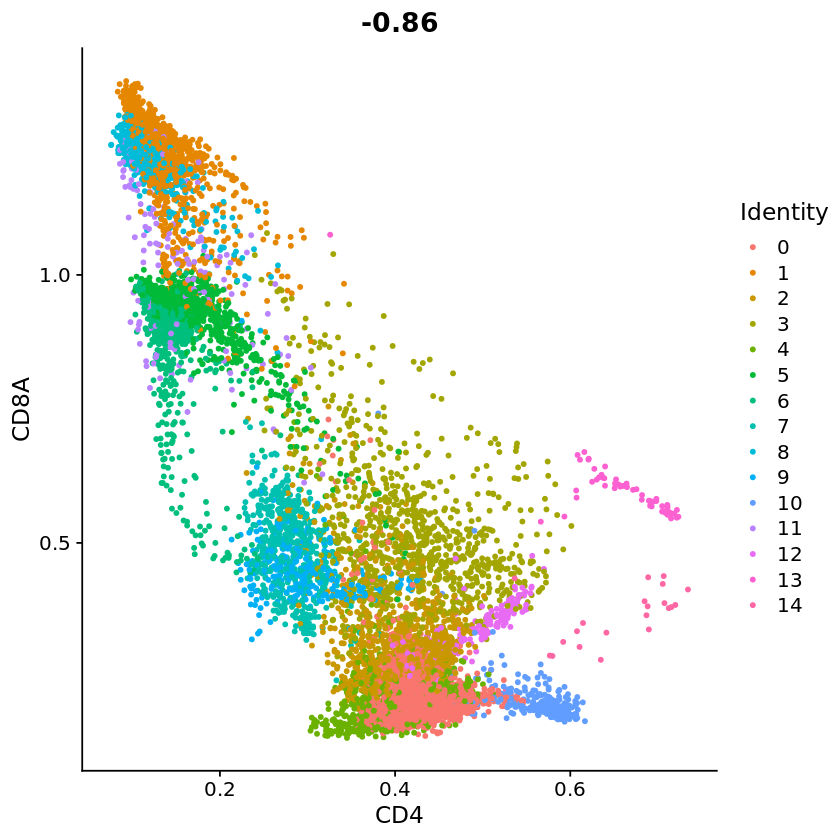

In [24]:
FeatureScatter(pbmc, feature1 = "CD4", feature2 = "CD8A")
FeatureScatter(pbmc_imputed, feature1 = "CD4", feature2 = "CD8A")

#### Overall, we can see a much more striking distinction between CD4 and CD8 in the smoothed/imputed data

## Try it yourself
* What is the specificity of the features used in gene scores compared to transcripts in scRNA-seq? Are there scenarios where one may be preferred over the other?
* Why do we log-scale the gene scores for visualization? 
* Describe the basics of the [MAGIC](http://gph.is/1KjihQe) algorithm, either by [reading the manuscript](https://pubmed.ncbi.nlm.nih.gov/29961576/) or from thinking through the function. 
* Think through some of the pros and cons associated with the imputation / smoothing of gene scores. When might the application of the imputation method [come back to bite you](https://www.youtube.com/watch?v=o0u4M6vppCI)?
* What was the rationale for the number of LSI dimensions in the UMAP and Cluster determination? Hint: try the  `DepthCor()` function.
* Are imputed gene scores stable across a choice of hyperparameters? How could you go about testing this? (Hint: [Molecular Cross-Validation](https://www.biorxiv.org/content/10.1101/786269v1) provides one such framework).

# Section 4: ATAC-seq things

Thus far, we've gone through the trouble of quality control, dimension reduction, marker gene identification, and cluster annotation-- all tasks common between scATAC-seq and scRNA-seq workflows. Now we're finally ready to see how to leverage the innate ATAC component to these single-cell tasks.

## Footprinting with single-cell data
Here, we'll use built-in functionality from Signac to perform TF footprinting. This requires us to set up a MotifObject in our Seurat/Signac object. Broadly speaking, this object will coordinate the positions of motif matches with a given peak. Most of this functionality relies on the [motifmatchr](https://www.bioconductor.org/packages/release/bioc/html/motifmatchr.html) package. We're going to focus on two motifs: CEBPA ('MA0102.3') and EBF1 ('MA0154.3'). See the comment for where we would normally have everything run. 

In [25]:
DefaultAssay(pbmc) <- 'peaks'

# extract position frequency matrices for the motifs
pwm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)[c('MA0102.3','MA0154.3')] # don't do this subset if you want to look at all motifs

# create a Motif object and add it to the assay
motif.matrix <- CreateMotifMatrix(
  features = granges(pbmc),
  pwm = pwm,
  genome = 'hg19',
  use.counts = FALSE
)

# Retain the actual motif matched positions, down to the base pair
motif.positions <- matchMotifs(
  pwms = pwm,
  subject = granges(pbmc),
  out = 'positions',
  genome = 'hg19'
)

# Create a new Mofif object to store the results
motif <- CreateMotifObject(
  data = motif.matrix,
  positions = motif.positions,
  pwm = pwm
)

# Store all of this back in the Seurat object
pbmc <- SetAssayData(
  object = pbmc,
  slot = 'motifs',
  new.data = motif
)

We can check out the motif object as a sanity check to see what we've now added to our overall object. 

In [26]:
motif

A Motif object containing 2 motifs in 90357 regions

In [27]:
# gather the footprinting information for sets of motifs
pbmc <- Footprint(
  object = pbmc,
  motif.name = c("CEBPA", "EBF1"),
  genome = BSgenome.Hsapiens.UCSC.hg19,
  in.peaks = TRUE
)


Computing Tn5 insertion bias

Extracting reads in requested region

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand cut sites

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand cut sites



Now that this computation is done, we can visualize the per-cluster insertion spectra.

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 7665 rows containing missing values (geom_label_repel)."


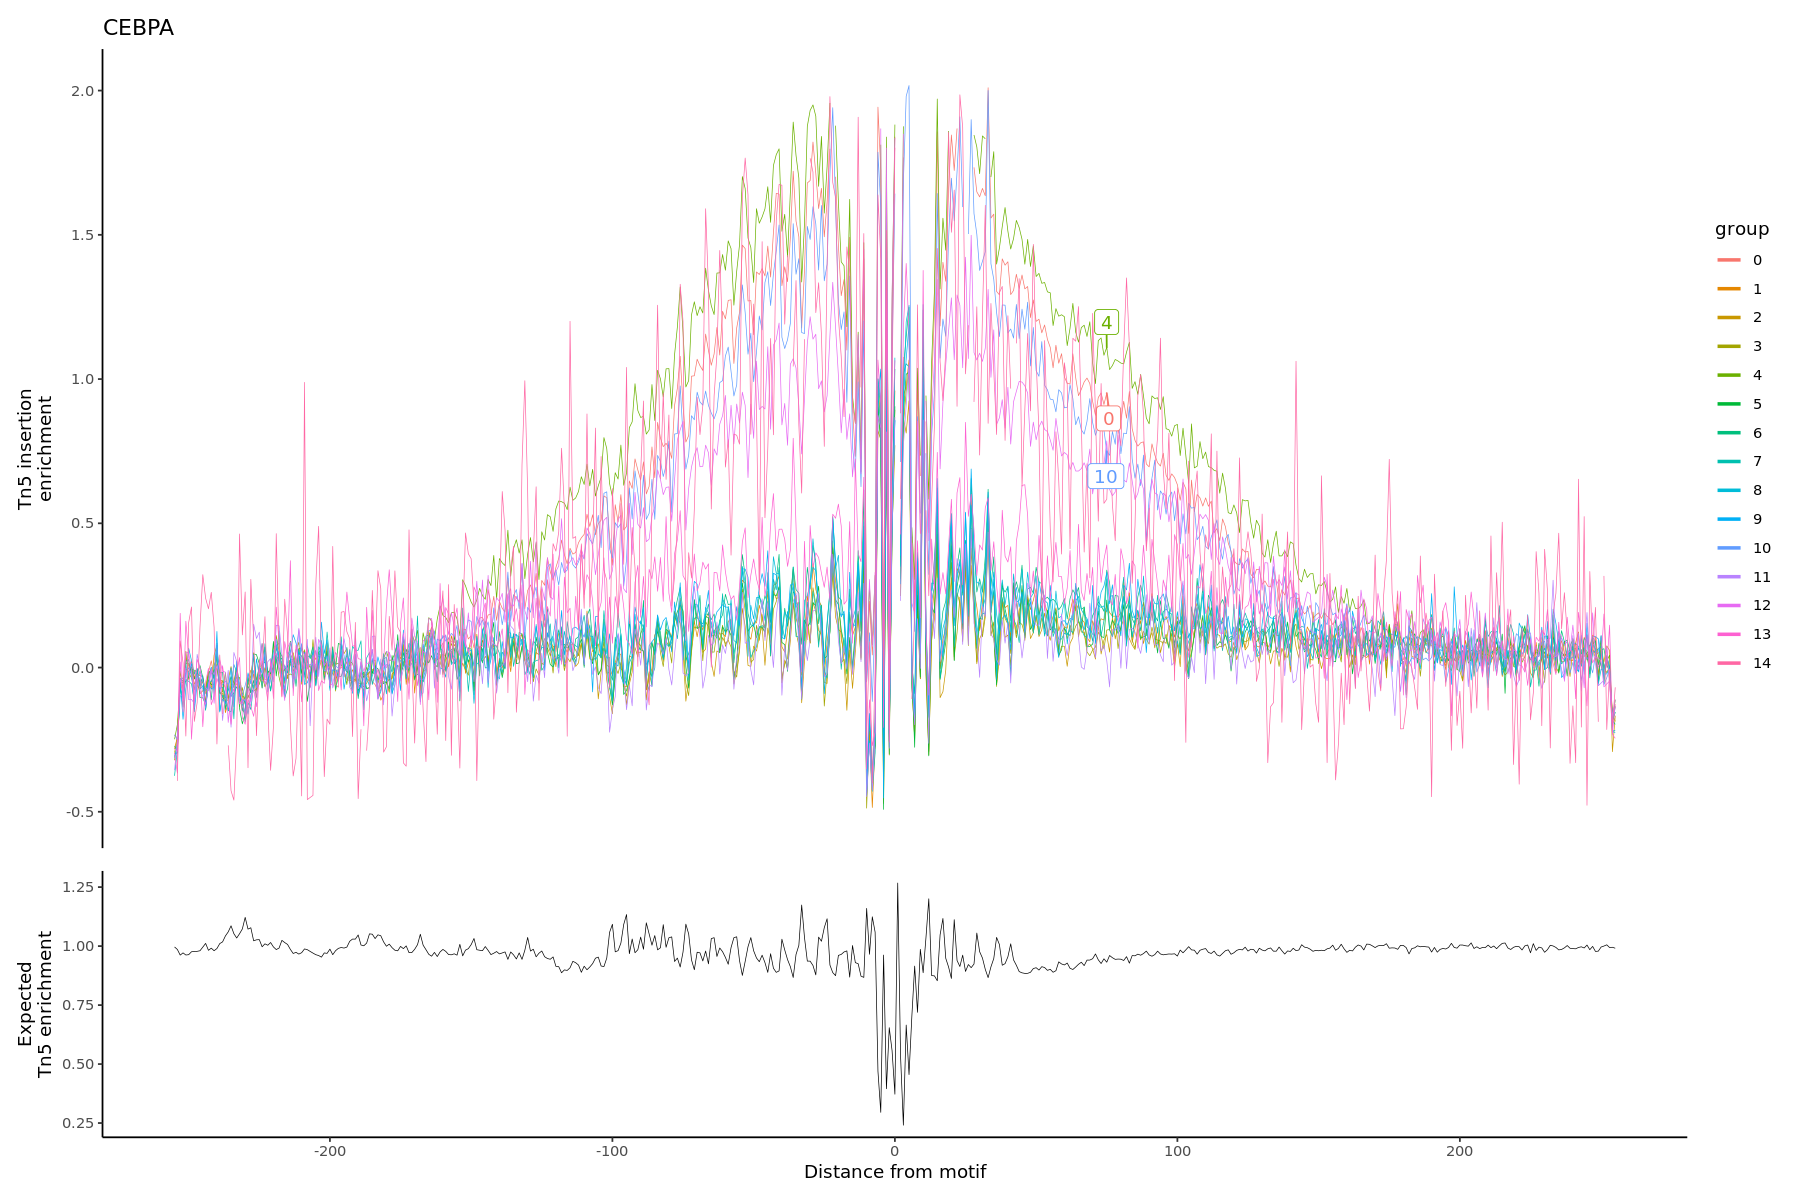

In [28]:
options(repr.plot.width=15, repr.plot.height=10)
PlotFootprint(pbmc, features = c("CEBPA"))


Warning message:
"Removed 7710 rows containing missing values (geom_label_repel)."


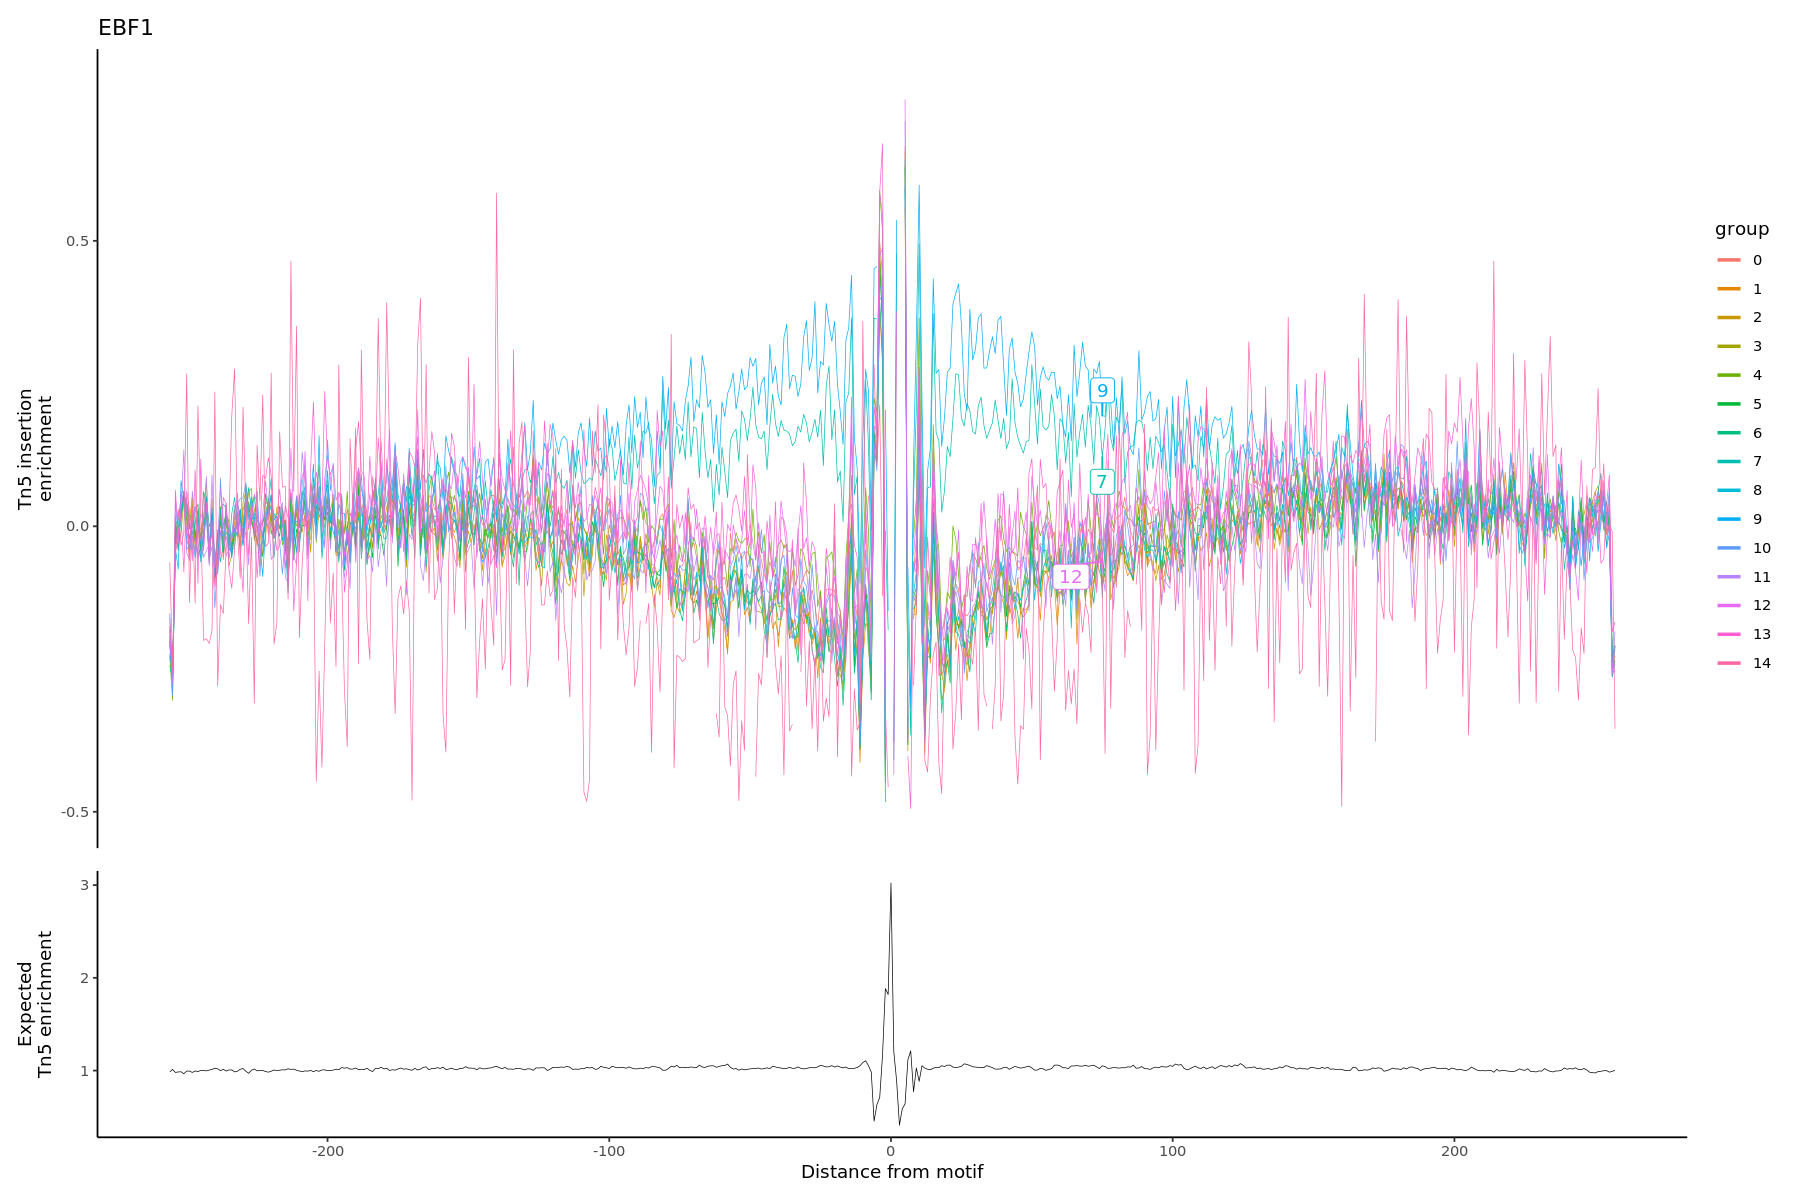

In [29]:
options(repr.plot.width=15, repr.plot.height=10)
PlotFootprint(pbmc, features = c( "EBF1"))


In [30]:
# Note the cluster 14 line looks erratic-- it's likely due to the small number of cells
table(pbmc@meta.data$seurat_clusters)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14 
2393  993  969  967  668  624  570  527  511  310  264  173  161   56   24 

Recall the DimPlot above that showed the various clusters. We can see that the cluster that peaks for insertions around the CEBPA motif are monocyte/myeloid cells whereas clusters that peak around EBF1 are B-cells. 

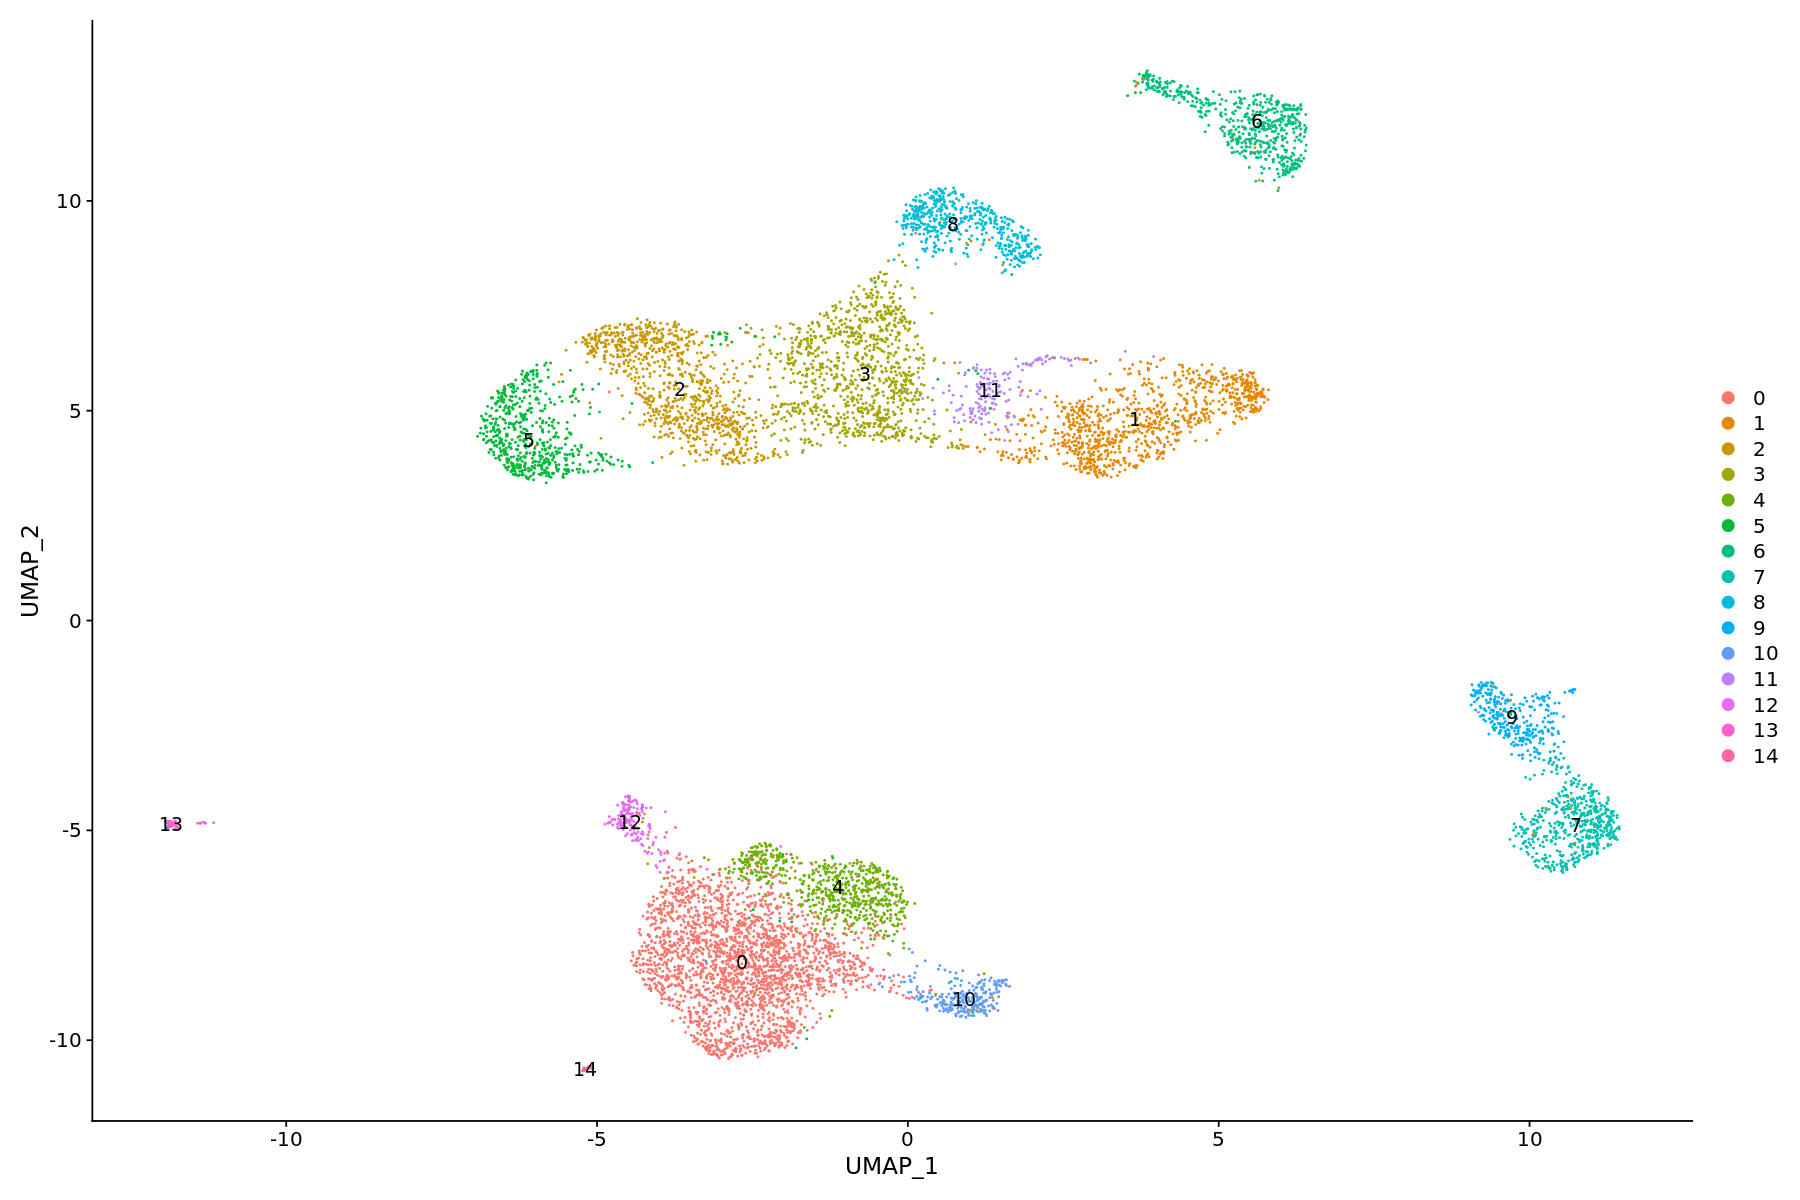

In [31]:
DimPlot(object = pbmc, label = TRUE)

We can also visualize the actual motif associated with these two factors that we visualized the footprints for:

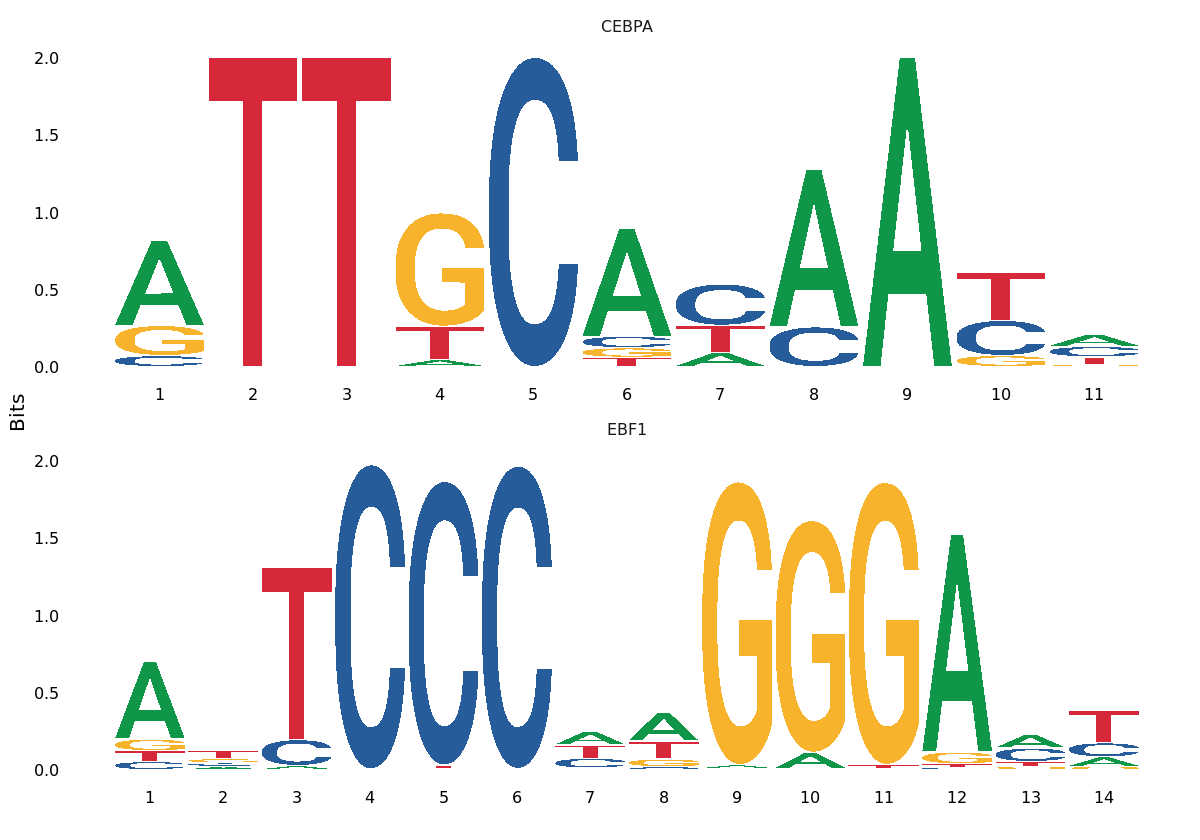

In [32]:
options(repr.plot.width=10, repr.plot.height=7)

MotifPlot(
  object = pbmc,
  motifs =  c('MA0102.3','MA0154.3'),
  assay = 'peaks', ncol = 1
)

## chromVAR

One of the ["original" tools](https://giphy.com/gifs/old-lit-betty-white-Rk927btUSH5eW0Hlbs) for analyzing scATAC-seq data is [chromVAR](https://greenleaflab.github.io/chromVAR/articles/Introduction.html). The basis of the chromVAR approach is to determine the extent to which a certain transcription factor may be active in a cetain individual cell. While footprinting is non-sensible at the single-cell level, "deviation scores" from chromVAR are useful at this resolution. 

The resulting chromVAR deviation score is a measure of how much more accessible chromatin is found at peaks that have compatibility with a motif than would be expected due to chance. The "due to chance" part of chromVAR is it's secret sauce-- [take a look at the original paper](https://pubmed.ncbi.nlm.nih.gov/28825706/) for more details on how this works. 

While Signac/Seurat provides wrapper functions to plug directly into chromVAR, we'll break down these pieces a bit to understand their composite parts. 

Notably, chromVAR uses the core Bioconductor object called a [RangedSummarizedExperiment](https://www.bioconductor.org/packages/devel/bioc/vignettes/SummarizedExperiment/inst/doc/SummarizedExperiment.html), which provides many nice features to essentially augment a matrix with complex row data (corresponding to genomic loci), complex columns (similar to Seurat via a data frame) and arbitrarily many "assays" that define features assocaited with a cell and a region (such as Tn5 inserts). We can create this (Ranged)SummarizedExperiment object by taking out a few pieces from the Seurat object like so: 

In [33]:
# This SummarizedExperiment object recycles a lot of the Signac/Seurat object
SE <- SummarizedExperiment(
    rowRanges = granges(pbmc),
    assays = list(counts = pbmc@assays$peaks@counts),
    colData = pbmc@meta.data
    )


Unfortunately, this alone isn't going to play nicely with chromVAR's downstream functions without a bit of modifications. Specifically, there are a subset of peaks that have 0 cells with a non-zero entry, which causes chromVAR to throw an error. We can quickly get rid of them using the "filterpeaks" fucntion. 

In [ ]:
SE <- addGCBias(SE,
                BSgenome.Hsapiens.UCSC.hg19)
SE <- filterPeaks(SE)
dim(SE)

We can reproduce this new peak number as expected:

In [ ]:
non_zero_peak <- rowSums(pbmc@assays$peaks@counts) > 0
table(non_zero_peak)

Fortunately, we need to do this to run the main chromVAR function, "computeDeviations". We can subset the matrix of matches motifs from above by similarly filtering the motif match matrix to make sure the dimensions are all nice and tidy:

In [ ]:
dev <- computeDeviations(SE, motif.matrix[non_zero_peak,])

The resulting object, "dev" is also a SummarizedExperiment, this time the number of motifs of interest (in our case 2) by the number of cells analysed (still [over 9,000](http://gph.is/1m8YIhZ)). We can directly add this back into our original Seurat object to take advantage of the built in visualization functions:

In [ ]:
# Rename for convenience
zmat <- assays(dev)$z
rownames(zmat) <- c("CEBPA", "EBF1")
pbmc[['chromvar']] <- CreateAssayObject(zmat)

In [ ]:
DefaultAssay(pbmc) <- 'chromvar'

# look at the activity of these two factors
FeaturePlot(
  object = pbmc,
  features = c('MA0102.3','MA0154.3'),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)


Thus, we can see that the clusters with the highest deviations correspend to those that had distinct insertion profiles for the same factors and largely match the biological expectation for the lineages that these factors were thought to be associated with. 

## Final questions
* What aspects of ATAC-seq analyses that were introduced in bulk weren't discussed in the single-cell tutorial? Are these amendable to a single-cell workflow? Why or why not? 
* What were the most time-consuming parts of the workflow? How could you structure analyses to minimize time spent while computation is rendering (e.g. what parameters would you refine clusters)? Recall that we only collected a subset of motifs and gene activity scores. 
* How could you go about discovering enriched transcription factors in individual clusters? What lines of code would you need to change to make this happen? 


## Summary
Recall some of the highlights of what was discussed today:
* How to interpret QC parameters from the 10x scATAC report
* Importing data into R and applicable data structures for scATAC-seq
* Use of the fragments file in analyses (e.g. gene scoring) and other potential applications (footprinting)
* How to perform dimensionality reduction and feature scoring using scATAC-seq data
* Utilizing smoothing/imputation approaches (i.e. MAGIC)
* Performing cluster-level epigenomic analyses (e.g. footprinting)

## Additional resources
* [Integration and label transfering with RNA-seq / Signac](https://satijalab.org/signac/articles/pbmc_vignette.html). This also discusses how to generate accessible chromatin tracks by simply extending the workflow here.
* [Cicero](https://cole-trapnell-lab.github.io/cicero-release/docs_m3/) provides functionality for pseudotime, enhancer-gene connections, and much more.
* [Batch correction and integration / Signac](https://satijalab.org/signac/articles/integration.html)
* Andrew Hill has a [very useful blogpost](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) that constrasts possible versions of LSI.
* [Dimension reduction and analyses with CisTopics](https://rawcdn.githack.com/aertslab/cisTopic/8d15fa2813312aa0b20c1042604079558829e947/vignettes/10X_workflow.html). The tool works well but is relatively slow and hard to use with larger datasets.
* [EpiScanpy](https://github.com/colomemaria/epiScanpy) is a new tool building off of the popular python tool Scanpy for single-cell epigenomics data analysis. For those that 
* [SnapATAC](https://github.com/r3fang/SnapATAC) provides a computationally efficient processing of data and many useful functionalities. This provides one echo
* [HINT software](https://www.regulatory-genomics.org/hint/tutorial/) for more advanced TF footprinting analyses. 
* [Autoencoder framework for scATAC-seq](https://www.nature.com/articles/s41467-019-12630-7) are theoretically more powerful apporaches 
* [ArchR](https://www.archrproject.com/) is a tool from Will Grenleaf's lab tha provides several advanced features and was written with scalable analyses in mind. For users with very large datasets, it is a useful tool to try. 

## Followup
We hope that this was informative. As you are working through this, if you have any questions/thoughts or feedback, please [Email Caleb](mailto:clareau@stanford.edu) about them. 